# 使用MindSpore构造并训练VGG网络
本小节介绍了VGG网络的原理，并且展示了如何使用MindSpore实现VGG网络。

## 1、实验目的
- 了解VGG网络原理。
- 掌握如何使用MindSpore构造并训练VGG网络。

## 2、VGG网络原理介绍
VGG 网络是卷积神经网络中的一种，在 2014 的 ImageNet 竞赛中，获得了定位任务第一名和分类任务第二名的好成绩。VGG在2014年由牛津大学著名研究组VGG(Visual Geometry Group)提出[(Simonyan K etal.,2014)](https://arxiv.org/pdf/1409.1556.pdf)。  
VGG有两种结构，分别是VGG16和VGG19，两者除了网络深度不一样，其本质并没有什么区别。相对于2012年的AlexNet， VGG的一个高进是采用连续的3x3小卷积核来代替AlexNet中较大的卷积核（AlexNet采用了11x11，7x7与5x5大小的卷积核）。两个3x3步长为1的卷积核的叠加，其感受野相当与一个5x5的卷积核。但是采用堆积的小卷积核是由于大卷积核的，因为层数的增加，增加了网络的非线性，从而能让网络来学习更复杂的模型，并且小卷积核的参数更少。  
通常所说的VGG网络是指VGG-16。虽然其屈居亚军，但是由于其规律的设计、简洁可堆叠的卷积块，且在其他数据集上都有着很好的表现，VGG网络被人们广泛使用。VGG和之前的AlexNet相比，深度更深，参数更多(1.38亿)，效果和可移植性更好。  
下图上半部分是常见的VGG网络结构，可以看见输入图片是224*224的RGB图像，经过卷积、池化与全连接操作后输出1000个分类结果；下半部分是五段卷积组，每一段卷积组后接一个最大池化层，最后由3层全连接层输出分类结果。   
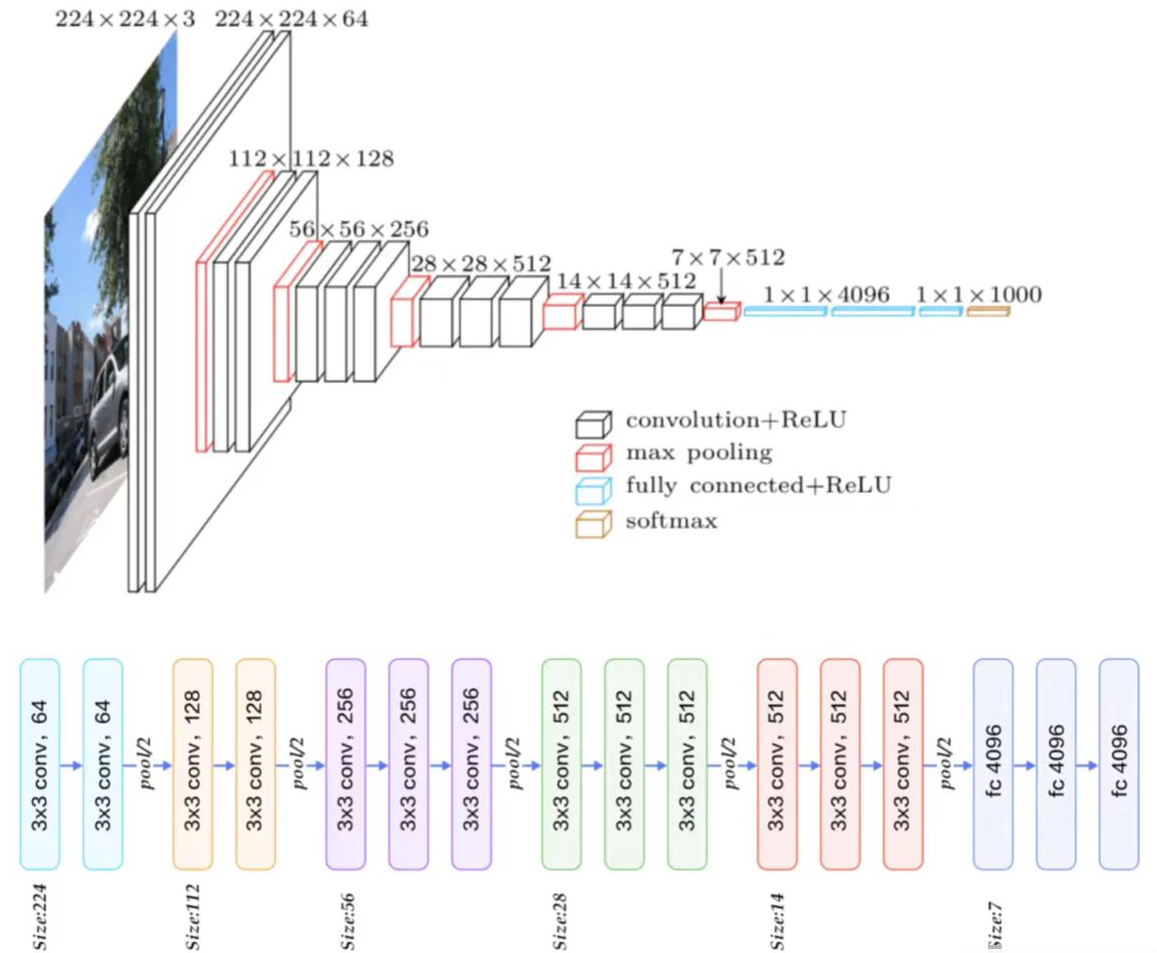  

## 3、实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4、数据处理

### 4.1 下载数据集

CIFAR-10数据集共有60000张32*32的彩色图像，分为10个类别，每类有6000张图，数据集一共有50000张训练图片和10000张评估图片。首先，如下示例使用download接口下载并解压，目前仅支持解析二进制版本的CIFAR-10文件（CIFAR-10 binary version）。

In [1]:
# 使用download 来下载 CIFAR-10 数据集
# !pip install download
from download import download
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"
download(url, "./datasets-cifar10-bin", kind="tar.gz")

Creating data folder...

file_sizes: 100%|████████████████████████████| 170M/170M [00:04<00:00, 41.2MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./datasets-cifar10-bin


'./datasets-cifar10-bin'

下载后的数据集目录结构如下：

datasets-cifar10-bin/cifar-10-batches-bin  
├── batches.meta.text  
├── data_batch_1.bin  
├── data_batch_2.bin  
├── data_batch_3.bin  
├── data_batch_4.bin  
├── data_batch_5.bin  
├── readme.html  
└── test_batch.bin  

### 4.2 训练和测试数据集的构建
Numpy模块主要用于数据的基本运算操作。MindSpore相关模块主要用于搭建网络、调用优化器、读取数据集和将数据集处理成网络的标准输入格式。

In [2]:
import numpy as np

import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore import nn, ops

ms.set_context(mode=ms.GRAPH_MODE, device_target='CPU')

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin"   # 数据集根目录
batch_size = 64                                            # 批量大小
image_size = 32                                            # 训练图像空间大小
workers = 6                                                # 并行线程个数
num_classes = 10                                           # 分类数量

batch_size,image_size,workers,num_classes

(64, 32, 8, 10)

### 4.3 利用mindspore.dataset中的函数Cifar10Dataset对CIFAR-10数据集进行处理
对于训练集，首先进行随机裁剪和随机翻转的操作。使用mindspore.dataset.vision.RandomCrop对输入图像进行随机区域的裁剪,大小为(32, 32)。(4, 4, 4, 4)表示在裁剪前，将在图像上下左右各填充4个像素的空白。使用mindspore.dataset.RandomHorizontalFlip,对输入图像按50%的概率进行水平随机翻转。

In [3]:
def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):
    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    # 需要做的变化的集合
    trans = []
    
    # 对于训练集，首先进行随机裁剪和随机翻转的操作。
    # 使用mindspore.dataset.vision.RandomCrop对输入图像进行随机区域的裁剪,大小为(32, 32)。(4, 4, 4, 4)表示在裁剪前，将在图像上下左右各填充4个像素的空白。
    # 使用mindspore.dataset.RandomHorizontalFlip,对输入图像按50%的概率进行水平随机翻转
    
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    # 对数据集进行大小、规模的重组，以及归一化（帮助模型收敛）
    
    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    #对于label进行的操作
    target_trans = [(lambda x: np.array([x]).astype(np.int32)[0])]

    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)

    data_set = data_set.map(
        operations=target_trans,
        input_columns='label',
        num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set

利用上面写好的那个函数，获取处理后的训练与测试数据集。

In [4]:
# 利用上面写好的那个函数，获取处理后的训练与测试数据集
dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()
index_label_dict = dataset_train.get_class_indexing()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

step_size_val,step_size_train,index_label_dict,dataset_train

(157,
 782,
 {},
 <mindspore.dataset.engine.datasets.BatchDataset at 0xffff256663d0>)

展示训练集的数据。

Image shape: (64, 3, 32, 32), Label: [8 3 4 0 0 9 8 1 6 5 4 8 9 3 0 1 8 4 3 6 6 4 3 3 8 1 9 7 2 7 5 6 7 4 8 4 4
 4 7 9 5 0 9 2 5 6 0 2 0 7 8 6 8 2 8 1 4 7 1 0 1 4 6 1]


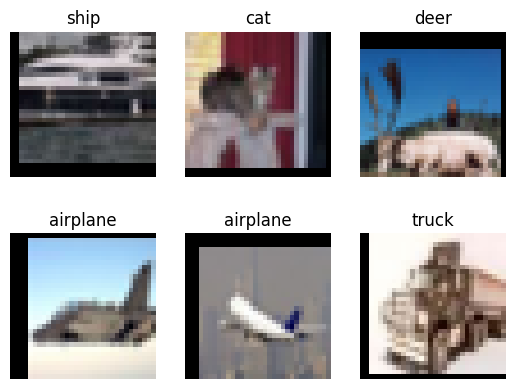

In [5]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")

classes = []

with open(data_dir+"/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line != '':
            classes.append(line)

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
# 展示训练集的数据（标签与原图）
plt.show()

## 5、模型构建
原始模型vgg16输入image大小是224*224，这里使用的数据集输入大小为32*32，缩小7倍。可以根据需要的大小来调整，比如如果输入的image大小是224*224，那么由于224/32=7，因此就把第一个nn.Dense的参数改成512*7*7，其他不变。

In [6]:
# 构建VGG网络
class VGG16(nn.Cell):
    def __init__(self):
        super().__init__()
        numClasses = 10
        self.all_sequential = nn.SequentialCell(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 原始模型vgg16输入image大小是224*224，这里使用的数据集输入大小为32*32，缩小7倍
            # 可以根据需要的大小来调整，比如如果输入的image大小是224*224，那么由于224/32=7，因此就把第一个nn.Dense的参数改成512*7*7，其他不变
            nn.Flatten(),
            nn.Dense(512*1*1, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Dense(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Dense(64, numClasses),
        )

    def construct(self, x):
        x = self.all_sequential(x)
        return x

## 6、模型训练

训练前，需要在与notebook文档同目录下新建一个vgg_ckpt文件夹，把该案例在github中提供的预训练权重文件下载后放在该文件夹下。

In [8]:
import time

import mindspore as ms
# 定义VGG16网络，并加载预训练模型。
vgg16 = VGG16()
param_dict = ms.load_checkpoint("./vgg_ckpt/vgg16-best.ckpt")
param_not_load = ms.load_param_into_net(vgg16, param_dict)

params_all = vgg16.get_parameters()

trainable_params = vgg16.trainable_params()
trainable_params_len = len(trainable_params)

# param.requires_grad = True表示所有参数都需要求梯度进行更新。
for param in vgg16.trainable_params()[0:trainable_params_len-1]:
    param.requires_grad = False


# 设置训练的轮数和学习率，这里训练的轮数设置为1
num_epochs = 1
#基于余弦衰减函数计算学习率。学习率最小值为0.0001，最大值为0.0005，具体API见文档https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.cosine_decay_lr.html?highlight=cosine_decay_lr
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.0005, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Adam(params=vgg16.trainable_params(), learning_rate=lr)
# 交叉熵损失
loss_fn = nn.CrossEntropyLoss()

#前向传播，计算loss
def forward_fn(inputs, targets):
    logits = vgg16(inputs)
    loss = loss_fn(logits, targets)
    return loss

#计算梯度和loss
grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)

def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

# 实例化模型
model = ms.Model(vgg16, loss_fn, opt, metrics={"Accuracy": nn.Accuracy()})


# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/vgg16-best.ckpt"

import os
import stat

# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    losses = []
    vgg16.set_train()

    # 为每轮训练读入数据

    for i, (images, labels) in enumerate(data_loader_train):
        loss = train_step(images, labels)
        if i%50 == 0 or i == step_size_train -1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]'%(
                epoch+1, num_epochs, i+1, step_size_train, loss))
        losses.append(loss)

    # 每个epoch结束后，验证准确率

    acc = model.eval(dataset_val)['Accuracy']

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, sum(losses)/len(losses), acc
    ))
    print("-" * 50)

    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        if os.path.exists(best_ckpt_path):
            os.chmod(best_ckpt_path, stat.S_IWRITE)#取消文件的只读属性，不然删不了
            os.remove(best_ckpt_path)
        ms.save_checkpoint(vgg16, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
Epoch: [  1/  1], Steps: [  1/782], Train Loss: [1.070]
Epoch: [  1/  1], Steps: [ 51/782], Train Loss: [0.764]
Epoch: [  1/  1], Steps: [101/782], Train Loss: [0.851]
Epoch: [  1/  1], Steps: [151/782], Train Loss: [0.954]
Epoch: [  1/  1], Steps: [201/782], Train Loss: [0.810]
Epoch: [  1/  1], Steps: [251/782], Train Loss: [0.756]
Epoch: [  1/  1], Steps: [301/782], Train Loss: [0.918]
Epoch: [  1/  1], Steps: [351/782], Train Loss: [1.002]
Epoch: [  1/  1], Steps: [401/782], Train Loss: [1.099]
Epoch: [  1/  1], Steps: [451/782], Train Loss: [0.508]
Epoch: [  1/  1], Steps: [501/782], Train Loss: [0.963]
Epoch: [  1/  1], Steps: [551/782], Train Loss: [0.644]
Epoch: [  1/  1], Steps: [601/782], Train Loss: [0.724]
Epoch: [  1/  1], Steps: [651/782], Train Loss: [0.644]
Epoch: [  1/  1], Steps: [701/782], Train Loss: [0.858]
Epoch: [  1/  1], Steps: [751/782], Train Loss: [0.796]
Epoch: [  1/  1], Steps: [782/782], Train Loss: [0.888]
------------------------

## 7、模型预测
验证和评估效果并且将效果可视化。显示图像及图像的预测值，使用测试数据集进行验证。

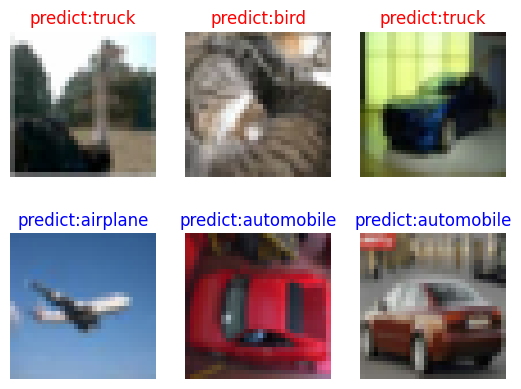

In [9]:
# 验证和评估效果并且将效果可视化

import matplotlib.pyplot as plt

def visualize_model(best_ckpt_path, dataset_val):
    net = VGG16()
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = []

    with open(data_dir+"/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line != '':
                classes.append(line)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)